# Notebook 5 - Clasificación K-Nearest Neighbours


In [0]:
import numpy   as np
import scipy   as sc
import pandas  as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn import preprocessing

In [2]:
wine_data = load_wine()

print(wine_data.DESCR)

def one_hot(params, classes):
  results = []
  for param in params:
    zeros = np.zeros(classes)
    zeros[param] = 1
    results.append(zeros)
  return results

X = wine_data.data.T
Y = wine_data.target# [:, np.newaxis]

Y_one_hot = one_hot(Y.T, 3)


.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

## 1. Visualizando KNN
---

**Tu tarea:** Implementa una función ***visualize_KNN($X_1$, $X_2$, $Y$, $k$, $dist$)*** que tome como parámetros de entrada dos variables de entrada $x1$ y $x2$ y el vector de etiquetas $Y$ , para que se encargue de visualizar un scatter plot donde se vean estas dos variable de entradas graficadas, indentificando por color el tipo de clase a la que pertence. Esta función deberá de utilizar los parámetros de entrada $k$ (número de valores a usar por KNN) y $dist$ (tipo de función que mide la distancia entre dos puntos) para realizar un KNN que prediga la clase para todas las combinaciones de puntos que se pueden generar en dicho scatter plot, para así poder sobreimpresionar un mapa de color que nos muestre la frontera de decisión del modelo. En la siguiente imagen puedes ver un ejemplo del resultado que se espera obtener:

![texto alternativo](http://www.mtechprojects.org/wp-content/uploads/2017/12/k-Nearest-Neighbor.png)

Una vez hayas implementado tu función, prueba a graficar diferentes variables, para diferentes valores de K y funciones de distancia.

1. ¿Cómo varía el comportamiento de las predicciones según variamos el valor de K?
2. ¿Cómo varía el comportamiento de las predicciones con diferente tipos de funciones de distancia?

**Pista:** Puede serte util para este ejercicio conocer las funciones ***np.meshgrid()*** y ***plt.pcolormesh()***.


In [0]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

c_de_color_map = mpl.colors.ListedColormap([[.2, .8, 1], [.2, 1, .2], [1, .5, .2]])

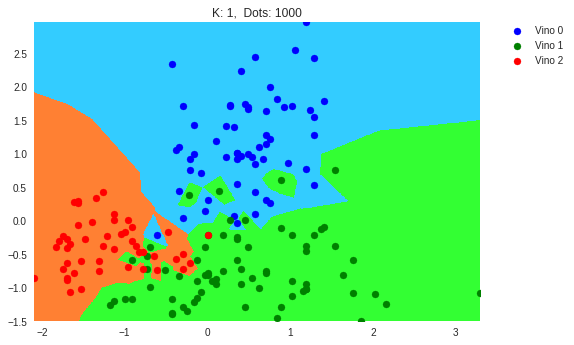

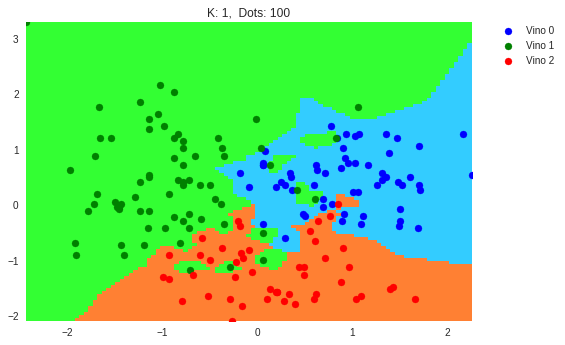

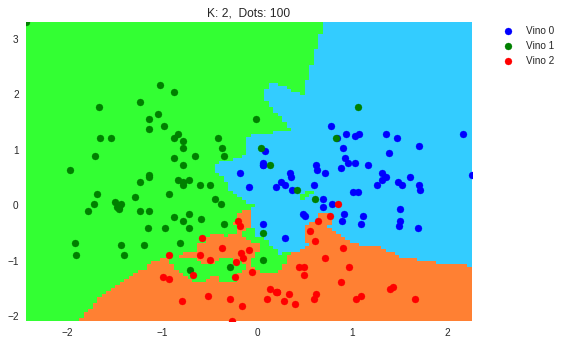

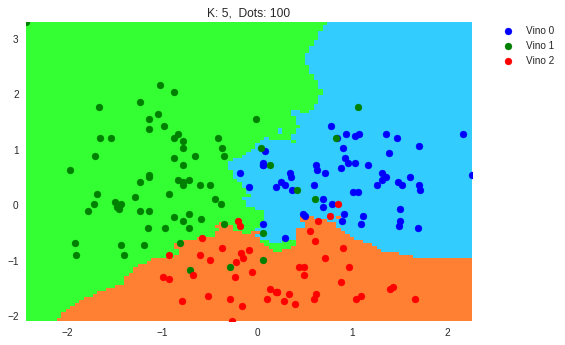

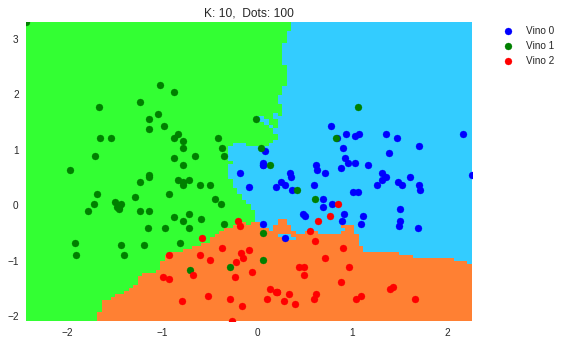

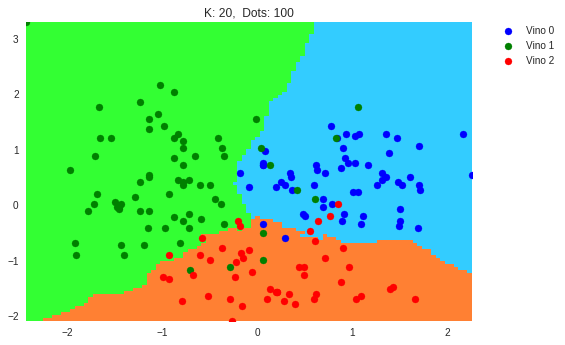

In [4]:
import scipy.spatial

# Por si quieres usar KD_Tree para mejorar el rendimiento
USE_KDTREE = True

def k_nearest(X, Y, k, dist, point, tree):
    
  # Tenemos que ordenar los puntos para saber cual son los más cercanos
  # Podemos ordenarlos con el sort de toda la vida o con un KD-Tree
  def comparator(a):
    '''return dist(np.array([a[0], a[1]]), point)'''
    return dist(a[0], a[1], point[0], point[1])
  
  all_data = np.hstack((X, Y))
  if USE_KDTREE:
    # https://stackoverflow.com/questions/42825579/find-closest-k-points-for-every-point-in-row-of-numpy-array
    dd, ii = tree.query(point, k=k, p=2)
    sorted_data = all_data[ii]
    if k == 1:
      sorted_data = [sorted_data] #why kdtree, why?
  else:
    sorted_data = sorted(all_data, key=comparator)[:k]
    
  
  # Obtenemos el que tiene más probabilidad (más puntos cercanos tiene)
  probabilities = np.zeros(3)
  for data in sorted_data:
     probabilities[int(data[2])] += 1 # 1 / comparator(data) # también se puede usar la distancia que tiene como relevancia
  
  probabilities = np.array([p / k for p in probabilities])
  
  return probabilities.argmax(axis=0)
  

def visualize_KNN(X1 , X2 , Y , k , dist, partitions):
  # formateamos variables de entrada
  X1, X2, Y = [x.reshape(len(X1),1) for x in [X1, X2, Y]]
  X1, X2 = [preprocessing.scale(x) for x in [X1, X2]]
  
  # generamos la malla para mostrar el grid
  x1_lns = np.linspace(np.min(X1), np.max(X1), partitions)
  x2_lns = np.linspace(np.min(X2), np.max(X2), partitions)
  mesh_X, mesh_Y = np.meshgrid(x1_lns, x2_lns)
    
  # aquí iran los resultados, de que color pintaremos cada zona
  z = np.zeros(mesh_X.shape)
  
  # juntamos los campos X
  X_ = np.hstack((X1, X2))
  tree = None
      
  if USE_KDTREE: # Usa KD Tree si no quieres estar esperando mucho
    tree = scipy.spatial.cKDTree(X_)
  
  # pues a calcular el k_nearest para cada
  for i, x in enumerate(x1_lns):
    for j, y in enumerate(x2_lns):
      z[j,i] = k_nearest(X_, Y, k, dist, np.array([x, y]), tree)
     
   
  plt.title("K: " + str(k) + ',  Dots: ' + str(partitions))
  plt.xlim(np.min(X1), np.max(X1))
  plt.ylim(np.min(X2), np.max(X2))
      
  # resultado del k_nearest
  plt.pcolormesh(mesh_X, mesh_Y, z, cmap=c_de_color_map, vmin=0, vmax=2)
  
  # puntos de la muestra
  plt.scatter(X1[Y == 0], X2[Y == 0], c='blue', label='Vino 0')
  plt.scatter(X1[Y == 1], X2[Y == 1], c='green', label='Vino 1')
  plt.scatter(X1[Y == 2], X2[Y == 2], c='red', label='Vino 2')
  
  # plt.scatter(mesh_X, mesh_Y, c='black', marker='.')
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  
  plt.show()
  

# funciones de distancia
'''def distance(a, b):
  return np.linalg.norm(a-b)'''

def distance(i,j,ip,jp):
  return (i-ip)**2+(j-jp)**2


# puedes coger la que quieras
visualize_KNN(X[10], X[12], Y, 1, distance, 1000 )
visualize_KNN(X[0], X[10], Y, 1, distance, 100 )
visualize_KNN(X[0], X[10], Y, 2, distance, 100 )
visualize_KNN(X[0], X[10], Y, 5, distance, 100 )
visualize_KNN(X[0], X[10], Y, 10, distance, 100 )
visualize_KNN(X[0], X[10], Y, 20, distance, 100 )


## 2. Seleccionando la K usando Cross-Validation

Como hemos visto en la teoría, para seleccionar los valores del hiperparámetro K en el algoritmo de K-Nearest Neighbours, necesitamos realizar una división de nuestro conjunto de datos al igual que hacíamos previamente con el conjunto de *train* y *test*. 

Una vez hecha la división probamos a separar con k-nearest los puntos con diferentes *k* hasta obtener el mejor parámetro.

---
Esta es una implementación sin usar la función score de SKLearn. Mejor mira el código siguiente.
No me hago responsable de si el código funciona bien :D

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def nearest_neighbors_test():

  train_validationX, testX, train_validationY, testY = train_test_split(X.T, np.matrix(Y).T, train_size=0.70, test_size=0.30)

  def score(rows, trainY, testY):
    corrects = 0

    for i, row in enumerate(rows):
      (values,counts) = np.unique(np.array(trainY[row]).ravel(), return_counts=True)
      ind=np.argmax(counts)
      if values[ind] == testY[i,0]:
        corrects += 1

    return corrects / len(rows)


  scores = []

  for k in range(1, 15):
    knn = NearestNeighbors(n_neighbors=k, p=2)
    kf = KFold(n_splits=10, shuffle=True)

    sum_score = 0

    for train_index, validation_index in kf.split(train_validationX):
      trainX = train_validationX[train_index]
      validationX = train_validationX[validation_index]
      trainY = train_validationY[train_index]
      validationY = train_validationY[validation_index]

      knn.fit(trainX, trainY)
      sum_score += score(knn.kneighbors(validationX, return_distance=False), trainY, validationY)



    knn.fit(train_validationX, train_validationY)
    n = knn.kneighbors(testX, return_distance=False)

    scores.append(sum_score / kf.get_n_splits())

    print(k)
    print('Validation', sum_score / kf.get_n_splits() * 100, '%')
    print('Test      ', score(n, train_validationY, testY) * 100, '%')
    print('----------')


  best = np.argmax(scores) + 1
  knn = NearestNeighbors(n_neighbors=best, p=2)
  knn.fit(train_validationX, train_validationY)
  n = knn.kneighbors(testX, return_distance=False)

  print('\nEl mejo è', best)
  print('\nTest     ', score(n, train_validationY, testY) * 100, ' %')
  return (best, score(n, train_validationY, testY))
  
nearest_neighbors_test()

1
Validation 73.33333333333333 %
Test       74.07407407407408 %
----------
2
Validation 65.96153846153847 %
Test       68.51851851851852 %
----------
3
Validation 68.33333333333333 %
Test       64.81481481481481 %
----------
4
Validation 71.60256410256412 %
Test       64.81481481481481 %
----------
5
Validation 73.39743589743588 %
Test       72.22222222222221 %
----------
6
Validation 75.64102564102565 %
Test       70.37037037037037 %
----------
7
Validation 74.29487179487181 %
Test       66.66666666666666 %
----------
8
Validation 72.75641025641025 %
Test       64.81481481481481 %
----------
9
Validation 68.33333333333333 %
Test       66.66666666666666 %
----------
10
Validation 71.21794871794872 %
Test       62.96296296296296 %
----------
11
Validation 63.46153846153847 %
Test       64.81481481481481 %
----------
12
Validation 67.94871794871796 %
Test       62.96296296296296 %
----------
13
Validation 66.92307692307692 %
Test       70.37037037037037 %
----------
14
Validation 70.9615

(6, 0.7037037037037037)

Esta si es la versión guay usando el método score de SKLearn, junto con una gráfica representando el score. Lo mejor en este caso es coger menos de los 20 primeros puntos

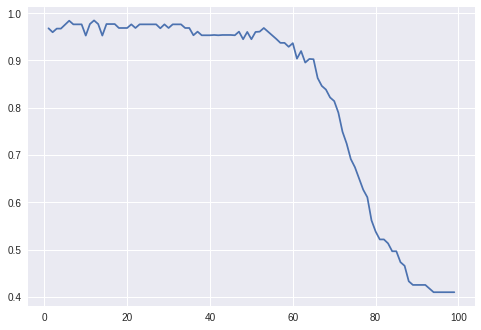

Best  12
Score 0.9629629629629629


In [6]:
from sklearn.neighbors import KNeighborsClassifier

def kneighbors_test():

  train_validationX, testX, train_validationY, testY = train_test_split(X.T, Y.T, train_size=0.70, test_size=0.30)
  
  train_validationX = preprocessing.scale(train_validationX, with_mean=True, with_std=True)
  testX = preprocessing.scale(testX, with_mean=True, with_std=True)

  # print(train_validationX, testX, train_validationY, testY)
  
  scores = []

  k_max = 100
  
  for k in range(1, k_max):
    knn = KNeighborsClassifier(n_neighbors=k, p=2)
    kf = KFold(n_splits=10)

    sum_score = 0

    for train_index, validation_index in kf.split(train_validationX):
      trainX = train_validationX[train_index]
      validationX = train_validationX[validation_index]
      trainY = train_validationY[train_index]
      validationY = train_validationY[validation_index]

      knn.fit(trainX, trainY.astype(int))
      sum_score += knn.score(validationX, validationY)

    
    scores.append(sum_score / kf.get_n_splits())
    
  plt.plot(np.arange(1,k_max,1), scores)
  plt.show()
  
  knn = KNeighborsClassifier(n_neighbors=np.argmax(scores) + 1, p=2)
  knn.fit(trainX, trainY.astype(int))
  
  print('Best ', np.argmax(scores) + 1)
  print('Score', knn.score(testX, testY))
  
  
  
# cross_val_score
kneighbors_test()

Extrañamente usando categorical la función los scores que nos devuelven no son consistentes. Posiblemente haya algún error o no se este usando el fit de manera correcta.

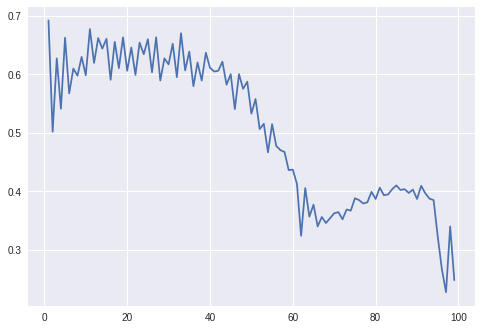

Best  1
Score 0.7407407407407407


In [8]:
def kneighbors_test_one_hot():

  train_validationX, testX, train_validationY, testY = train_test_split(X.T, one_hot(Y, 3), train_size=0.70, test_size=0.30)

  # print(train_validationX, testX, train_validationY, testY)
  
  scores = []

  for k in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=k, p=2)
    kf = KFold(n_splits=10, shuffle=True)

    sum_score = 0

    for train_index, validation_index in kf.split(train_validationX):
      trainX = train_validationX[train_index]
      validationX = train_validationX[validation_index]
      
      trainY = np.matrix(train_validationY)[train_index]
      validationY = np.matrix(train_validationY)[validation_index]

      knn.fit(trainX, trainY.astype(int))
      sum_score += knn.score(validationX, validationY)

    
    scores.append(sum_score / kf.get_n_splits())
    
  plt.plot(np.arange(1,100,1), scores)
  plt.show()
  
  knn = KNeighborsClassifier(n_neighbors=np.argmax(scores) + 1, p=2)
  kf = KFold(n_splits=10, shuffle=True)
  knn.fit(trainX, np.matrix(trainY).astype(int))
  print('Best ', np.argmax(scores) + 1)
  print('Score', knn.score(testX, np.matrix(testY)))
  
  
kneighbors_test_one_hot()